# Building Trustworthy Simulations

In this notebook, we will discuss how to implement and evaluate the simulations discussed in earlier lessons from this week. 

## Coffee Shop Simulation

We will begin by implementing the Coffee Shop simulation discussed in an earlier lesson from this week. For convenience, we set the code for this simulation within a function – this function takes `n_max` (the maximum customers) and `T_max`, the maximum time, and returns customer arrival times `A`, departure times `D`, inter-arrival times `H`, service times `S`, and final customer number `n`. 

In [1]:
import math
import random

def run_coffee_shop_sim(n_max,T_max):
  #initialize variables as empty lists
  A = [0]*n_max #arrival times
  D = [0]*n_max #departure times
  H = [0]*n_max #inter-arrival times
  S = [0]*n_max #service times
  #run simulation
  for n in range(n_max):
    #inter arrival
    H[n]=-math.log(random.random())/(9/60)
    so=random.random()*(50/60)+(10/60) #order placing time    
    sd=0 #time for making drinks
    d_tot=random.randint(1,6) #number of drinks 
    #calculate total time needed to make drinks
    for d in range(d_tot):
      r=random.random()
      if r<0.4: # if Americano...
        sd=sd+random.random()*0.5 
      else:
        if r<0.7: # if Cappucino...
          sd=sd+random.random()+2 
        else: # if Latte...
          sd=sd+random.random()*3+1  
    #compute variables       
    S[n]=so+sd
    A[n]=A[n-1]+H[n]
    D[n]=S[n]+max(A[n],D[n-1])
    #stopping condition
    if D[n]>T_max:          
          break

  return A, D, H, S, n      

We also define a function to measure average customer time in the shop (i.e., $TimeInShop$ from a previous lesson), after removing a certain number of customers in the initial warmup period. 

In [2]:
import numpy as np
#average time in shop
def TimeInShop(A,D,n,warmup):
  return (1/(n-warmup))*sum(np.array(D[warmup+1:n])-np.array(A[warmup+1:n]))

We can now run the simulation, using 6 hours as a maximum time (chosen to be appropriate for a coffee shop), and 1000 as a customer maximum – since the termination condition is based on `T_max`, this can be a high number. We set `random.seed` to an integer value, to ensure that we can reproduce the results of our simulation if we run this cell again.

In [3]:
#run simulation
n_max= 1000
T_max = 6*60
random.seed(1)
A, D, H, S, n = run_coffee_shop_sim(n_max,T_max)

To look at the outcome of our simulation, we can plot the time in shop for each customer in order (departure time minus arrival time). There is a lot of variability, but the increase in time in shop at the beginning suggests that we should get rid of about the first 10 customers as warmup. 

Text(0, 0.5, 'Customer Time in Shop')

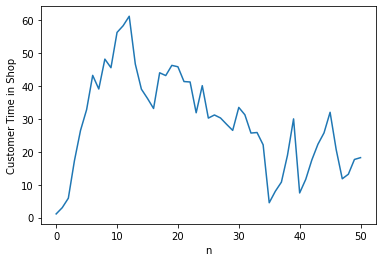

In [4]:
import matplotlib.pyplot as plt

#plot TimeInShop for each customer
TimeInShop_inst = list(np.array(D)-np.array(A))
plt.plot(range(n),TimeInShop_inst[:n])
plt.xlabel('n')
plt.ylabel('Customer Time in Shop')

We are particularly interested in reporting the average time spent in this coffee shop. Since there is potentially a lot of variation between simulation runs, we want to run the simulation many times and take an average – in other words, compute average $TimeInShop$. How many runs should we use? The code below runs the simulation for an increasing number of runs (specified by `sim_count`), computes average value of time in the shop, $TimeInShop$, for each of these runs after discarding warmup, and prints `sim_count`, mean $TimeInShop$ and the standard deviation of $TimeInShop$ for each of these sets of runs. 


In [5]:
for sim_count in [5,10,25,50,100,500,1000,5000,10000]:
  TimeInShop_vec = []
  for sim in range(sim_count):
    n_max= 1000
    T_max = 6*60
    A, D, H, S, n = run_coffee_shop_sim(n_max,T_max)
    TimeInShop_vec.append(TimeInShop(A,D,n,warmup=10))
    
  print(sim_count,np.mean(TimeInShop_vec),np.std(TimeInShop_vec))
  

5 29.456659834254605 26.591629765077904
10 26.023004577278424 13.745991195704168
25 27.862172166099914 15.916869097224252
50 25.62517132758524 15.326311968201507
100 24.194646567868475 14.115460941735316
500 25.675733220986473 13.54321689184811
1000 26.53477317399295 15.26187640615908
5000 25.46135115754775 14.311478737805658
10000 25.829323113493217 14.565236895453758



We can see that with increasing numbers of runs, the initially variable mean $TimeInShop$ estimate becomes more stable, as does the estimate of the standard deviation of $TimeInShop$. This later quantity will never fully disappear, as the simulation contains natural variability. Instead, both the average and standard deviation converge in value as the number of runs increases. These numbers suggest that we likely should have at least 100 runs of our simulation to report a mean $TimeInShop$. 

Another way to look at this is to see that as  the number of runs increases, the standard deviation of estimates of mean $TimeInShop$ will decrease. The code below takes many samples of mean $TimeInShop$ for increasing numbers of runs, and computes and prints the standard deviation of average estimates for each `sim_count`. 

As we can see, as `sim_count` increases, the standard deviation of the estimate decreases. 

In [6]:
for sim_count in [5,10,25,75,100,200]:
  sample_means = []
  for sample in range(100): 
    TimeInShop_vec = []
    for sim in range(sim_count):
      n_max= 1000
      T_max = 6*60
      A, D, H, S, n = run_coffee_shop_sim(n_max,T_max)
      TimeInShop_vec.append(TimeInShop(A,D,n,warmup=10))
    sample_means.append(np.mean(TimeInShop_vec))
  print(sim_count, np.std(sample_means))

5 6.00035307023354
10 4.899759338683591
25 2.892187991971778
75 1.39942338567149
100 1.4965355635457427
200 0.9581387554031164


## Repair Facility Simulation

Similarly for the repair facility scenario, we define a function to run the simulation, this time taking an `n_max` (maximum number of failures), and returning arrival, departure, inter-failure, and repair times, as well as final failure number `n` pre-halt. 

In [7]:
def run_repair_facility_sim(n_max,S_0=5):
  #initialize variables as empty lists
  A = [0]*n_max #arrival times
  D = [0]*n_max #departure times
  F = [0]*n_max #inter-failure times
  S = [0]*n_max #repair times
  #run simulation
  for n in range(n_max):
    F[n]=-math.log(random.random())/1.0 
    #use rejection method to simulate repair time
    ok=False
    while ok==False:
      x=random.random(); y=random.random()
      if x<0.6:
        if y<(5/3)*x:
          ok=True
      else:
        if y<2.5-2.5*x:
          ok=True
    #compute variables      
    S[n]=x
    A[n]=A[n-1]+F[n]
    D[n]=S[n]+max(A[n],D[n-1])
    #stopping condition
    if n>S_0 and A[n]<D[n-S_0]:
      
      break
    
  return A, D, F, S, n


We also define a function that computes the number of arrivals and departures there have been in the repair facility at any given time, allowing us to calculate the machines in repair at time `t`.

In [8]:
#machines in repair at time t
def N(A, D, n, t):
  #arrivals at time t
  num_arrivals = len([i for i in A[:n+1] if i<=t])
  #departures at time t
  num_departures = len([i for i in D[:n+1] if i<=t])
  #return number of customers in the shop
  return num_arrivals - num_departures

We can now run the simulation, and for an appropriate span of time, compute the number of machines in the repair facility. We then plot this over time. 

Text(0, 0.5, 'N(t)')

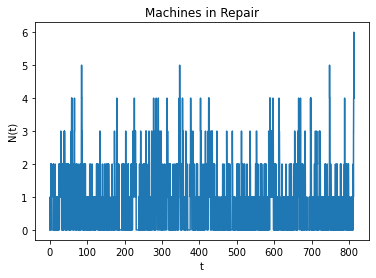

In [9]:
import matplotlib.pyplot as plt
import numpy as np
random.seed(10)
#run simulation
n_max= 1000

A, D, F, S, n = run_repair_facility_sim(n_max,S_0=5)
# times 
ts = list(np.arange(0,A[n]+1,1/60))
# num machines in repair at each time
Ns = [N(A,D,n,t) for t in ts]
# plot N over time
plt.plot(ts,Ns)
plt.title('Machines in Repair')
plt.xlabel('t')
plt.ylabel('N(t)')

We can see that right before halting, the number of machines in the repair facility spikes above the spare machine count. 

We again repeat our multiple runs of the simulation for increasing run counts. We see the same pattern as with the Coffee Shop simulation, where increasing counts lead to a stabilization of estimates for average time of first factory halt, and standard deviation of time of first halt. 

In [10]:
 for sim_count in [5,10,25,50,100,500,1000,5000,10000]:
  Halting_Times = []
  for sim in range(sim_count):
    n_max= 1000    
    A, D, F, S, n = run_repair_facility_sim(n_max,S_0=5)
    Halting_Times.append(A[n])
    
  print(sim_count,np.mean(Halting_Times),np.std(Halting_Times))
 

5 582.8867038019495 369.9642122224538
10 366.8900317999636 302.8707251683673
25 331.1570032993219 295.97473334457766
50 292.94526711287943 259.37604012627185
100 287.8286766807448 241.29265511747474
500 298.2818068969279 266.15447912436423
1000 296.3592488240543 261.4477628227398
5000 292.7348455368765 265.9224429043814
10000 296.0551640397607 266.8028344343982
